In [1]:
! pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import nltk
import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import anderson_ksamp
from scipy.stats import ks_2samp
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 1. Cotent and Bias Type, Class, Words definition

### 1.1 Define content to be analyzed

In [3]:
# Define content categories and list files for analysis
lifestyle_content_list = ['lifestyle_2.txt', 'lifestyle_3.txt', 'lifestyle_4.txt', 'lifestyle_5.txt', 'lifestyle_6.txt', 
                            'lifestyle_7.txt', 'lifestyle_8.txt', 'lifestyle_9.txt', 'lifestyle_10.txt', 'lifestyle_11.txt',
                            'lifestyle_12.txt', 'lifestyle_13.txt', 'lifestyle_14.txt', 'lifestyle_15.txt', 'lifestyle_16.txt', 
                            'lifestyle_17.txt',  'lifestyle_18.txt', 'lifestyle_19.txt', 'lifestyle_21.txt', 'lifestyle_20.txt']

social_content_list = ['social_politics_1.txt', 'social_politics_2.txt', 'social_politics_3.txt', 'social_politics_4.txt', 
                           'social_politics_5.txt', 'social_politics_13.txt', 'social_politics_14.txt', 'social_politics_15.txt', 
                           'social_politics_16.txt', 'social_politics_17.txt', 'social_politics_18.txt', 'social_politics_19.txt', 
                           'social_politics_20.txt', 'social_politics_22.txt', 'social_politics_21.txt', 'social_politics_23.txt', 
                           'social_politics_24.txt', 'social_politics_26.txt', 'social_politics_25.txt', 'social_politics_27.txt']

science_content_list = ['science_3.txt', 'science_1.txt', 'science_2.txt', 'science_4.txt', 'science_6.txt', 'science_7.txt', 
                           'science_9.txt', 'science_10.txt', 'science_14.txt', 'science_13.txt', 'science_15.txt', 
                           'science_16.txt', 'science_12.txt', 'science_17.txt', 'science_11.txt', 'science_18.txt', 
                           'science_19.txt', 'science_20.txt', 'science_21.txt', 'science_22.txt']

health_content_list = ['health_wellness_25.txt', 'health_wellness_24.txt', 'health_wellness_23.txt', 'health_wellness_22.txt', 
                          'health_wellness_21.txt', 'health_wellness_20.txt', 'health_wellness_19.txt', 'health_wellness_18.txt', 
                          'health_wellness_17.txt', 'health_wellness_6.txt', 'health_wellness_7.txt', 'health_wellness_8.txt', 
                          'health_wellness_9.txt', 'health_wellness_10.txt', 'health_wellness_11.txt', 'health_wellness_12.txt', 
                          'health_wellness_15.txt', 'health_wellness_16.txt', 'health_wellness_13.txt', 'health_wellness_14.txt']

academics_content_list = ['academics_17.txt', 'academics_16.txt', 'academics_15.txt', 'academics_14.txt', 'academics_13.txt', 
                             'academics_12.txt', 'academics_11.txt', 'academics_10.txt', 'academics_9.txt', 'academics_1.txt', 
                             'academics_2.txt', 'academics_6.txt', 'academics_7.txt', 'academics_8.txt', 'academics_18.txt', 
                             'academics_19.txt', 'academics_20.txt', 'academics_21.txt', 'academics_22.txt', 'academics_23.txt']


content_dict = {'lifestyle': lifestyle_content_list,
                'social': social_content_list,
               'science': science_content_list,
               'health': health_content_list,
               'academics': academics_content_list}

### 1.2 Define Bias Types, Bias Classes and Bias Words 

In [4]:
# bias classes and words
bias_types = {
    "race": {
        0: ["black", "African", "Afro"],
        1: ["white", "Caucasian", "European", "Anglo"],
        2: ["Asian", "Chinese", "Japanese", "Korean", "Indian"],
        3: ["Hispanic", "Latino", "Latina", "Mexican", "Spanish"],
        4: ["Native", "Indigenous"]
    },
    "gender": {
        0: ["man", "male", "boy", "gentleman", "husband", "son"],
        1: ["woman", "female", "girl", "lady", "wife", "daughter"]
    },
    "religion": {
        0: ["Christian", "Jesus", "Bible", "Church", "Catholic", "Protestant"],
        1: ["Muslim", "Islam", "Quran", "Mosque", "Muhammad"],
        2: ["Jewish", "Judaism", "Torah", "Synagogue", "Rabbi"],
        3: ["Hindu", "Hinduism", "Hindutva",],
        4: ["Buddhist", "Buddhism", "Dharma", "Sangha", "Buddha"],
        5: ["Atheist", "Atheism", "Agnostic", "Secular"]
    }
}

# 2. Calculating similarity scores

### 2.1 Load Word Vector and Ensure all Bias Words are in the Word Vector

In [5]:
model_path = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [6]:
# determine if the bias class words are in the model's vector space
for k, v in bias_types.items():
    print('.....evaluating ' + k)
    for words in v.values():
        #print(words)
        #print(type(words))
        for word in words:
            try:
                v = model[word]
            except KeyError:
                print(word)


.....evaluating race
.....evaluating gender
.....evaluating religion


### 2.2 Content clean up and processing 

In [7]:
# produces a list of list of words for each document within the topic

def read_and_preprocess(topic):
    stop_words = set(stopwords.words('english'))
    sentences = []  # This will store all sentences needed for Word2Vec scoring

    directory = 'content'
    for filename in os.listdir(directory):
        if filename in content_dict[topic]:
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                # Tokenization
                words = word_tokenize(text)
                # Removing stopwords and non-alphabetic tokens
                words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
                sentences.append(words)

    return sentences

In [8]:
# get similarity scores of all words within a document with respect to one bias type, e.g. racial bias
# Input: bias type, list of words and a word vector model
# Output: dictionary with similarity score of each class against each word in the list of words 

def get_similarity_scores(bias_type, words, model): 

    out_dict = {}

    # iterate over every bias class and bias words for each class
    for k, v in bias_type.items():           # k: class, e.g. 0 , v : words for that class e.g. white', 'caucasian'
        
        # collect all similarity scores in this list
        temp_sim_score = []

        # iterate over every bias word within the class
        for bias_word in v:

            # iterate over all words in a doc
            for word in words:

                # check if the word is actually in the word vector
                if word in model.key_to_index:
                    
                    # calculate similarity score and colect in the list
                    temp_sim_score.append(model.similarity(bias_word, word))


        # create an 2D array making it in the shape of (number of words in the doc, number of words in the bias class)
        temp_sim_arr = np.array(temp_sim_score)
        temp_sim_arr = temp_sim_arr.reshape( -1, len(v))

        # average out biases across all bias words in that class
        temp_sim_arr = np.average(temp_sim_arr, axis = 1)
        
        #print(f'{temp_sim_arr.shape}')
        
        # store average similarity scores oif all words of the bias class 
        out_dict[k] = temp_sim_arr

    return out_dict

In [9]:
#TEST CODE
test_scores = get_similarity_scores(bias_types['gender'] , read_and_preprocess('lifestyle')[0], model)
print(test_scores[0].shape)
print(test_scores)

test_scores = get_similarity_scores(bias_types['gender'] , read_and_preprocess('lifestyle')[19], model)
print(test_scores[0].shape)
print(test_scores)

(444,)
{0: array([ 9.31899548e-02,  9.48698446e-02,  8.10858086e-02,  9.02686417e-02,
        7.21508116e-02,  4.25796323e-02,  7.18830377e-02,  4.36456688e-02,
        6.15438521e-02,  5.22490740e-02,  2.71419454e-02,  6.49048015e-02,
        7.10587874e-02,  7.38135949e-02,  1.43531457e-01,  8.15962628e-02,
        2.76320782e-02,  2.46835053e-02,  6.20556213e-02,  9.12911296e-02,
        6.28727973e-02,  9.64372680e-02,  6.61663339e-02,  6.20417260e-02,
        5.82580157e-02,  1.10236429e-01,  2.59086583e-02,  5.68427853e-02,
        9.97904539e-02,  8.20411369e-02,  5.90805151e-02,  4.47425433e-02,
        1.12178653e-01,  4.62233312e-02,  5.91502935e-02,  5.72770685e-02,
        1.98366251e-02,  6.22050790e-03,  3.88696045e-02,  4.52803522e-02,
        3.64986397e-02,  4.48721834e-02,  5.26541509e-02,  2.34245490e-02,
        6.11084513e-02,  3.09648756e-02,  1.07419007e-01,  3.19624804e-02,
        7.88296163e-02,  4.62369956e-02,  4.89918701e-02,  4.15460728e-02,
        5.4618

In [10]:
# method to determine similarity scores for all content within a topic

def calculate_bias_scores(topic, bias_type):

    topic_content = read_and_preprocess(topic)
    
    sim_scores = []
    
    for content in topic_content:
        
        # calculate average similarity score
        sim_scores.append(get_similarity_scores(bias_types[bias_type], content, model))
        
    return sim_scores        
        

Below code returns a list of scores for each document. Each list element is a dictionary of the scores for each class

In [11]:
print('Getting lifestyle scores...')
lifestyle_gender_scores_list = calculate_bias_scores('lifestyle', 'gender')
lifestyle_religion_scores_list = calculate_bias_scores('lifestyle', 'religion')
lifestyle_race_scores_list = calculate_bias_scores('lifestyle', 'race')

print('Getting health scores...')
health_gender_scores_list = calculate_bias_scores('health', 'gender')
health_religion_scores_list = calculate_bias_scores('health', 'religion')
health_race_scores_list = calculate_bias_scores('health', 'race')

print('Getting social scores...')
social_gender_scores_list = calculate_bias_scores('social', 'gender')
social_religion_scores_list = calculate_bias_scores('social', 'religion')
social_race_scores_list = calculate_bias_scores('social', 'race')

print('Getting science scores...')
science_gender_scores_list = calculate_bias_scores('science', 'gender')
science_religion_scores_list = calculate_bias_scores('science', 'religion')
science_race_scores_list = calculate_bias_scores('science', 'race')

print('Getting academic scores...')
academic_gender_scores_list = calculate_bias_scores('academics', 'gender')
academic_religion_scores_list = calculate_bias_scores('academics', 'religion')
academic_race_scores_list = calculate_bias_scores('academics', 'race')


Getting lifestyle scores...
Getting health scores...
Getting social scores...
Getting science scores...
Getting academic scores...


# 3. Anderson Darling K-Sample Test

### 3.1 Run Tests

In [12]:
# run anderson darling ksamp test
# takes a dictionary of the {class: similarity scores}
# returns a result dictionary

def run_anderson_ksamp_test(scores):
    result = []

    for score in scores:

        score_list = [np.array(v) for v in score.values()]
        result.append(anderson_ksamp(score_list))

    return result

In [13]:
temp_result = anderson_ksamp([lifestyle_gender_scores_list[0][0], lifestyle_gender_scores_list[0][1]])
# Print the result
print(f"Statistic: {temp_result.statistic}")
print(f"Critical Values: {temp_result.critical_values}")
print(f"Significance Level: {temp_result.significance_level}")
print(f"P-value: {temp_result.significance_level}")

Statistic: 5.4811839727747484
Critical Values: [0.325 1.226 1.961 2.718 3.752 4.592 6.546]
Significance Level: 0.002340681070029156
P-value: 0.002340681070029156


In [14]:
lifestyle_gender_ksamp_stats = run_anderson_ksamp_test(lifestyle_gender_scores_list)
lifestyle_religion_ksamp_stats = run_anderson_ksamp_test(lifestyle_religion_scores_list)
lifestyle_race_ksamp_stats = run_anderson_ksamp_test(lifestyle_race_scores_list)


/var/folders/vc/l7405thn06zfd8zchzn3w96w0000gn/T/ipykernel_37762/2141899128.py:11: UserWarning: p-value capped: true value larger than 0.25
  result.append(anderson_ksamp(score_list))
/var/folders/vc/l7405thn06zfd8zchzn3w96w0000gn/T/ipykernel_37762/2141899128.py:11: UserWarning: p-value floored: true value smaller than 0.001
  result.append(anderson_ksamp(score_list))


In [15]:
health_gender_ksamp_stats = run_anderson_ksamp_test(health_gender_scores_list)
health_religion_ksamp_stats = run_anderson_ksamp_test(health_religion_scores_list)
health_race_ksamp_stats = run_anderson_ksamp_test(health_race_scores_list)

social_gender_ksamp_stats = run_anderson_ksamp_test(social_gender_scores_list)
social_religion_ksamp_stats = run_anderson_ksamp_test(social_religion_scores_list)
social_race_ksamp_stats = run_anderson_ksamp_test(social_race_scores_list)

science_gender_ksamp_stats = run_anderson_ksamp_test(science_gender_scores_list)
science_religion_ksamp_stats = run_anderson_ksamp_test(science_religion_scores_list)
science_race_ksamp_stats = run_anderson_ksamp_test(science_race_scores_list)

academic_gender_ksamp_stats = run_anderson_ksamp_test(academic_gender_scores_list)
academic_religion_ksamp_stats = run_anderson_ksamp_test(academic_religion_scores_list)
academic_race_ksamp_stats = run_anderson_ksamp_test(academic_race_scores_list)

/var/folders/vc/l7405thn06zfd8zchzn3w96w0000gn/T/ipykernel_37762/2141899128.py:11: UserWarning: p-value capped: true value larger than 0.25
  result.append(anderson_ksamp(score_list))
/var/folders/vc/l7405thn06zfd8zchzn3w96w0000gn/T/ipykernel_37762/2141899128.py:11: UserWarning: p-value floored: true value smaller than 0.001
  result.append(anderson_ksamp(score_list))


In [16]:
all_scores = {}

In [17]:
# Calculate K Sample stats for gender bias across topics 
topics = ['lifestyle', 'health', 'social', 'science', 'academic']
i = 0

for lst in [lifestyle_gender_ksamp_stats, 
            health_gender_ksamp_stats, 
            social_gender_ksamp_stats, 
            science_gender_ksamp_stats, 
            academic_gender_ksamp_stats]:
    print(topics[i])
    tmp_stat_lst = []
    for l in lst:
        tmp_stat_lst.append(l.statistic)

    print(str(tmp_stat_lst) + '\n')
    all_scores[topics[i] + '-' + 'gender'] = tmp_stat_lst
    
    i += 1

lifestyle
[5.4811839727747484, 1.5540345403954847, -0.0575518009694093, -0.48797760563617426, -0.48952416496224177, 6.880333963712771, 3.192947201669256, 8.534433921359646, 1.0708724246091073, -0.6743865421898533, -0.7133930884289328, -0.6324496155884646, -0.14261491532713264, -0.2886571336448771, -0.780681430393036, -0.17110684894586906, 1.2503202337227917, 0.6199638324742957, 3.2563942654369233, 1.6256570010039042]

health
[4.471555401794433, 1.5883730121262356, -0.5195929585651304, 0.852195442633701, -0.43600196764325966, 6.501225502724747, 2.6919124367031246, -0.7454270735387641, 4.5090259801607155, 2.2428618350734157, 4.3635477793856134, 2.718414894014171, 0.579818672684644, 1.9935604464104153, 1.665571801399787, -0.03513084592271075, 9.932808533924513, -0.2774330387348627, 0.8126531686034842, -0.7180824395529319]

social
[-0.5138707379145351, -0.5689468596020442, -0.12592049307184475, 0.5212129364188184, -0.8309299240238671, -0.14333339879349766, 1.8432578919634415, -1.0173263905

In [18]:
# Calculate K Sample stats for race bias across topics 
topics = ['lifestyle', 'health', 'social', 'science', 'academic']
i = 0

for lst in [lifestyle_race_ksamp_stats, 
            health_race_ksamp_stats, 
            social_race_ksamp_stats, 
            science_race_ksamp_stats, 
            academic_race_ksamp_stats]:
    print(topics[i])
    tmp_stat_lst = []
    for l in lst:
        tmp_stat_lst.append(l.statistic)

    print(str(tmp_stat_lst) + '\n')
    all_scores[topics[i] + '-' + 'race'] = tmp_stat_lst
    
    i += 1

lifestyle
[27.558147413347516, 65.49999552080342, 34.52162636347293, 128.4839472107946, 249.17625348792876, 21.625783501241937, 42.24310047628651, 86.92337625726961, 152.99816211558166, 12.31499366899404, 13.344149128786597, 65.77117551158722, 21.65632670937076, 73.51157956933885, 14.787150078020002, 24.35770163600039, 49.86983370675582, 63.41649189322459, 154.70410674969173, 17.7723449145185]

health
[24.828932140794272, 121.59289492727558, 24.88754707946289, 30.345218054275225, 61.58247592190013, 32.304970354365565, 128.65529303339045, 24.968471119588433, 141.0171789231272, 20.857366648445925, 91.77473598589994, 227.2677029817515, 26.398568537732995, 17.64484790858319, 36.399076331766885, 18.380168543764672, 150.20559594447894, 47.29758291943106, 28.58156929388561, 12.439890275086961]

social
[71.03955440540796, 40.71260014192443, 26.299646723025607, 56.04286606276931, 36.09490768929381, 22.363045808843868, 23.876546957471668, 32.241761537526116, 25.889202684022578, 16.98299449718461

In [19]:
# Calculate K Sample stats for religion bias across topics 
topics = ['lifestyle', 'health', 'social', 'science', 'academic']
i = 0

for lst in [lifestyle_religion_ksamp_stats, 
            health_religion_ksamp_stats, 
            social_religion_ksamp_stats, 
            science_religion_ksamp_stats, 
            academic_religion_ksamp_stats]:
    print(topics[i])
    tmp_stat_lst = []
    for l in lst:
        tmp_stat_lst.append(l.statistic)

    print(str(tmp_stat_lst) + '\n')
    all_scores[topics[i] + '-' + 'religion'] = tmp_stat_lst
    
    i += 1

lifestyle
[29.661923915051574, 57.39339779794397, 39.92951780545871, 220.6143029676497, 184.86015201470812, 19.909174899958696, 49.583580556474274, 68.36034057373196, 155.4066738852547, 36.23718775280636, 21.91598296214757, 68.32893973476644, 29.139890248111126, 92.95116760818583, 35.547885075939845, 29.17532910295042, 97.49505449432526, 65.62646146400978, 123.39697993710055, 11.470276800981095]

health
[36.693026472482174, 99.81865863777541, 66.11391983128274, 68.58704601440446, 100.78308779708966, 56.356721221357795, 62.646157919156856, 43.97474708346625, 90.90571594279811, 42.31292380046396, 51.64824022118224, 166.11488966674438, 104.63879299665778, 50.04540177419826, 9.32318304039343, 37.029610867025184, 121.57716609155341, 36.95151862818038, 24.412198663274527, 60.917516598965015]

social
[95.88810435009563, 55.22878496155205, 57.255720431297014, 54.03692491969588, 160.60879002427035, 29.18928280551671, 45.97641686851636, 71.50198293555314, 47.73745149349294, 57.107573086537755, 1

### 3.2 Anderson Darling Test Statistic for all documents for all bias classes

In [20]:
all_scores

{'lifestyle-gender': [5.4811839727747484,
  1.5540345403954847,
  -0.0575518009694093,
  -0.48797760563617426,
  -0.48952416496224177,
  6.880333963712771,
  3.192947201669256,
  8.534433921359646,
  1.0708724246091073,
  -0.6743865421898533,
  -0.7133930884289328,
  -0.6324496155884646,
  -0.14261491532713264,
  -0.2886571336448771,
  -0.780681430393036,
  -0.17110684894586906,
  1.2503202337227917,
  0.6199638324742957,
  3.2563942654369233,
  1.6256570010039042],
 'health-gender': [4.471555401794433,
  1.5883730121262356,
  -0.5195929585651304,
  0.852195442633701,
  -0.43600196764325966,
  6.501225502724747,
  2.6919124367031246,
  -0.7454270735387641,
  4.5090259801607155,
  2.2428618350734157,
  4.3635477793856134,
  2.718414894014171,
  0.579818672684644,
  1.9935604464104153,
  1.665571801399787,
  -0.03513084592271075,
  9.932808533924513,
  -0.2774330387348627,
  0.8126531686034842,
  -0.7180824395529319],
 'social-gender': [-0.5138707379145351,
  -0.5689468596020442,
  -0.12

### 3.3 Create avarage of the Anderson Darling Statistic across all documents

In [21]:
for k, v in all_scores.items():
    avg_score = np.mean(np.array(v))
    print(f"Category: {k}, Score : {avg_score}")
    

Category: lifestyle-gender, Score : 1.451389910553647
Category: health-gender, Score : 2.1095928291840673
Category: social-gender, Score : 1.7163037451064178
Category: science-gender, Score : 0.5716374954225364
Category: academic-gender, Score : 0.8771686951905961
Category: lifestyle-race, Score : 66.02681229565077
Category: health-race, Score : 63.371504346250376
Category: social-race, Score : 44.89992639021737
Category: science-race, Score : 40.96420572216544
Category: academic-race, Score : 40.53493723519207
Category: lifestyle-religion, Score : 71.8502109798778
Category: health-religion, Score : 66.5425261634226
Category: social-religion, Score : 69.81453823649987
Category: science-religion, Score : 62.076829000464436
Category: academic-religion, Score : 78.58775494743168


### 3.4 Create Charts

In [22]:
_FONT_SIZE = 14

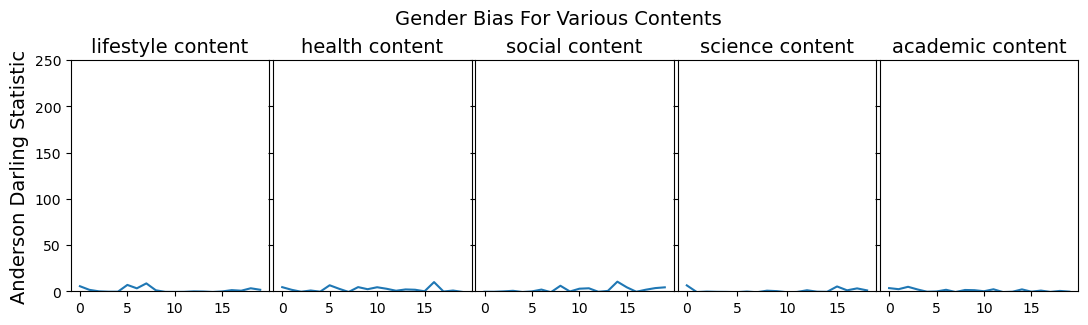

<Figure size 2000x2000 with 0 Axes>

In [23]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 3), sharey = True, gridspec_kw = dict(wspace=0.02) )
fig.suptitle('Gender Bias For Various Contents', y = 1.05, fontsize = _FONT_SIZE)
ax1.set_ylim(0, 250)

plt.figure(figsize=(20,20))
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : _FONT_SIZE}

plt.rc('font', **font)
plt.rc('font',family='Times New Roman')
#plt.xticks(fontsize=_FONT_SIZE)

for k, v in all_scores.items():        
    if 'gender' in k:
        
        if 'lifestyle' in k:
            ax1.set_title('lifestyle content', fontsize=_FONT_SIZE)
            ax1.plot(range(len(v)), v)
            ax1.set_xticks(np.arange(0, 20, 5.0))

            ax1.set_ylabel('Anderson Darling Statistic', fontsize = _FONT_SIZE)
        if 'health' in k:
            ax2.set_title('health content', fontsize=_FONT_SIZE)
            ax2.plot(range(len(v)), v)
            ax2.set_xticks(np.arange(0, 20, 5.0))
        if 'social' in k:
            ax3.set_title('social content', fontsize=_FONT_SIZE)
            ax3.plot(range(len(v)), v)
            ax3.set_xticks(np.arange(0, 20, 5.0))
        if 'science' in k:
            ax4.set_title('science content', fontsize=_FONT_SIZE)
            ax4.plot(range(len(v)), v)
            ax4.set_xticks(np.arange(0, 20, 5.0))
        if 'academic' in k:
            ax5.set_title('academic content', fontsize=_FONT_SIZE)
            ax5.plot(range(len(v)), v)
            ax5.set_xticks(np.arange(0, 20, 5.0))

fig.savefig('ad_gender.png')

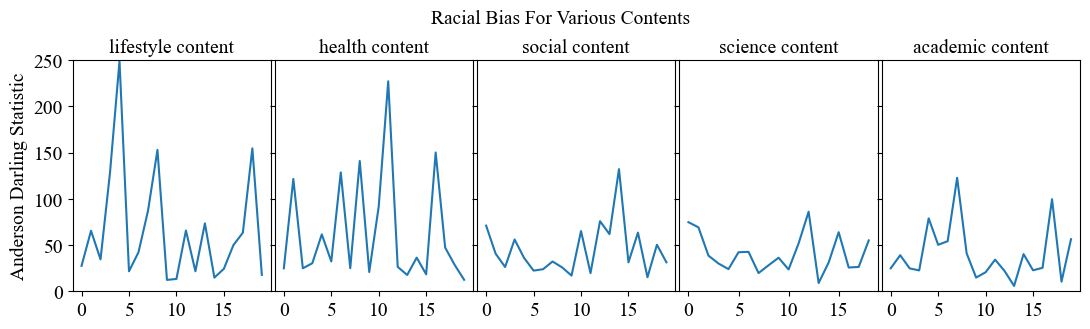

<Figure size 2000x2000 with 0 Axes>

In [24]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 3), sharey = True, gridspec_kw = dict(wspace=0.02) )
fig.suptitle('Racial Bias For Various Contents', y = 1.05, fontsize = _FONT_SIZE)
ax1.set_ylim(0, 250)

plt.figure(figsize=(20,20))
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : _FONT_SIZE}

plt.rc('font', **font)
plt.rc('font',family='Times New Roman')
#plt.xticks(fontsize=_FONT_SIZE)

for k, v in all_scores.items():        
    if 'race' in k:
        
        if 'lifestyle' in k:
            ax1.set_title('lifestyle content', fontsize=_FONT_SIZE)
            ax1.plot(range(len(v)), v)
            ax1.set_xticks(np.arange(0, 20, 5.0))

            ax1.set_ylabel('Anderson Darling Statistic', fontsize = _FONT_SIZE)
        if 'health' in k:
            ax2.set_title('health content', fontsize=_FONT_SIZE)
            ax2.plot(range(len(v)), v)
            ax2.set_xticks(np.arange(0, 20, 5.0))
        if 'social' in k:
            ax3.set_title('social content', fontsize=_FONT_SIZE)
            ax3.plot(range(len(v)), v)
            ax3.set_xticks(np.arange(0, 20, 5.0))
        if 'science' in k:
            ax4.set_title('science content', fontsize=_FONT_SIZE)
            ax4.plot(range(len(v)), v)
            ax4.set_xticks(np.arange(0, 20, 5.0))
        if 'academic' in k:
            ax5.set_title('academic content', fontsize=_FONT_SIZE)
            ax5.plot(range(len(v)), v)
            ax5.set_xticks(np.arange(0, 20, 5.0))


fig.savefig('ad_race.png')

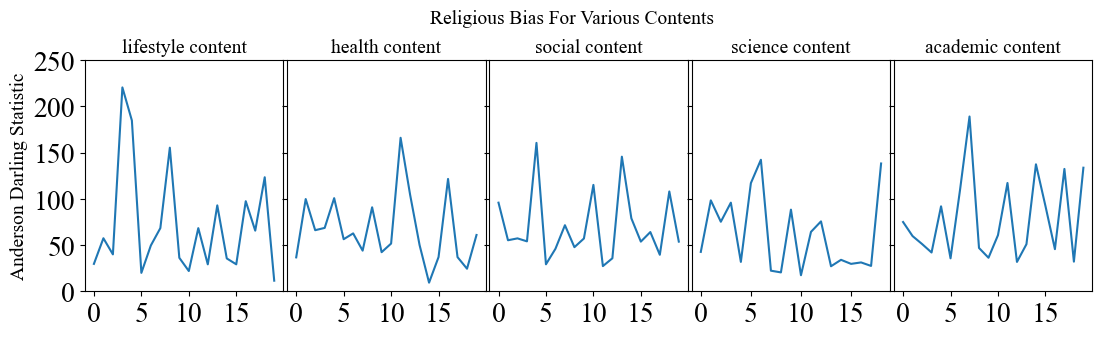

<Figure size 2000x2000 with 0 Axes>

In [94]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 3), sharey = True, gridspec_kw = dict(wspace=0.02) )
fig.suptitle('Religious Bias For Various Contents', y = 1.05, fontsize = _FONT_SIZE)
ax1.set_ylim(0, 250)

plt.figure(figsize=(20,20))
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : _FONT_SIZE}

plt.rc('font', **font)
plt.rc('font',family='Times New Roman')
#plt.xticks(fontsize=_FONT_SIZE)

for k, v in all_scores.items():        
    if 'religion' in k:
        
        if 'lifestyle' in k:
            ax1.set_title('lifestyle content', fontsize=_FONT_SIZE)
            ax1.plot(range(len(v)), v)
            ax1.set_xticks(np.arange(0, 20, 5.0))

            ax1.set_ylabel('Anderson Darling Statistic', fontsize = _FONT_SIZE)
        if 'health' in k:
            ax2.set_title('health content', fontsize=_FONT_SIZE)
            ax2.plot(range(len(v)), v)
            ax2.set_xticks(np.arange(0, 20, 5.0))
        if 'social' in k:
            ax3.set_title('social content', fontsize=_FONT_SIZE)
            ax3.plot(range(len(v)), v)
            ax3.set_xticks(np.arange(0, 20, 5.0))
        if 'science' in k:
            ax4.set_title('science content', fontsize=_FONT_SIZE)
            ax4.plot(range(len(v)), v)
            ax4.set_xticks(np.arange(0, 20, 5.0))
        if 'academic' in k:
            ax5.set_title('academic content', fontsize=_FONT_SIZE)
            ax5.plot(range(len(v)), v)
            ax5.set_xticks(np.arange(0, 20, 5.0))


fig.savefig('ad_religion.png')

# 4. Pairwise Kolmogorov-Smirnov Test

### 4.1 Define Utilities

In [95]:
# generate bias class pairs to compare from the number of classes

def get_pairs(max_num):
    combinations = []
    for i in range(max_num):
        for j in range(i + 1, max_num + 1):
            combinations.append((i, j))
    
    return combinations    



# Run pairwise Kolmogorov-Smirnov Test
def run_pairwise_ks_test(score_list):
    pair_ks_result_for_all_docs = []
    for score in score_list:          # pick score for each document
        num_bias_classes = len(score)

        # generate all pairs, e.g. for 3 bias classes, generate [(0, 1), (0, 2), (1, 2)]
        pair_list = get_pairs(num_bias_classes-1)
        
        # store the scores of a document for al pairwise test
        pair_ks_result_for_a_doc = {}
        
        for pair in pair_list:
            first_scores = score[pair[0]]
            second_scores = score[pair[1]]
            stat, p = ks_2samp(first_scores, second_scores)
            pair_ks_result_for_a_doc[pair] = (stat, p)

        pair_ks_result_for_all_docs.append(pair_ks_result_for_a_doc)
    return pair_ks_result_for_all_docs

In [96]:
# generates an average value of all pairwise KS scores across a list of scores

def get_average_pairwise_ks_scores(score_list):

    avg_statistic_for_all_docs = {}
    avg_p_for_all_docs = {}
    num_docs = 0
    
    for score_dict in score_list:
        
        # score_dict has the value (0, 1) as key and the values (0.11486486486486487, 0.005677322893336401) as value
        for k, v in score_dict.items():
            
            if k in avg_statistic_for_all_docs.keys():
                avg_statistic_for_all_docs[k] += v[0]
                avg_p_for_all_docs[k] += v[1]
            else:
                avg_statistic_for_all_docs[k] = v[0]
                avg_p_for_all_docs[k] = v[1]

        # increase number of docs by 1
        num_docs += 1

    for k, v in avg_statistic_for_all_docs.items():
        avg_statistic_for_all_docs[k] = v / num_docs

    for k, v in avg_p_for_all_docs.items():
        avg_p_for_all_docs[k] = v / num_docs
    
    return (avg_statistic_for_all_docs, avg_p_for_all_docs)

### 4.2 Calculate KS Scores

In [97]:
lifestyle_gender_pairwise_ks_scores = run_pairwise_ks_test(lifestyle_gender_scores_list)
lifestyle_race_pairwise_ks_scores = run_pairwise_ks_test(lifestyle_race_scores_list)
lifestyle_religion_pairwise_ks_scores = run_pairwise_ks_test(lifestyle_religion_scores_list)

health_gender_pairwise_ks_scores = run_pairwise_ks_test(health_gender_scores_list)
health_race_pairwise_ks_scores = run_pairwise_ks_test(health_race_scores_list)
health_religion_pairwise_ks_scores = run_pairwise_ks_test(health_religion_scores_list)

social_gender_pairwise_ks_scores = run_pairwise_ks_test(social_gender_scores_list)
social_race_pairwise_ks_scores = run_pairwise_ks_test(social_race_scores_list)
social_religion_pairwise_ks_scores = run_pairwise_ks_test(social_religion_scores_list)

science_gender_pairwise_ks_scores = run_pairwise_ks_test(science_gender_scores_list)
science_race_pairwise_ks_scores = run_pairwise_ks_test(science_race_scores_list)
science_religion_pairwise_ks_scores = run_pairwise_ks_test(science_religion_scores_list)

academic_gender_pairwise_ks_scores = run_pairwise_ks_test(academic_gender_scores_list)
academic_race_pairwise_ks_scores = run_pairwise_ks_test(academic_race_scores_list)
academic_religion_pairwise_ks_scores = run_pairwise_ks_test(academic_religion_scores_list)

### 4.3 Calculate KS Score Averages

In [98]:
lifestyle_gender_pairwise_ks_average = get_average_pairwise_ks_scores(lifestyle_gender_pairwise_ks_scores)
lifestyle_race_pairwise_ks_average = get_average_pairwise_ks_scores(lifestyle_race_pairwise_ks_scores)
lifestyle_religion_pairwise_ks_average = get_average_pairwise_ks_scores(lifestyle_religion_pairwise_ks_scores)

health_gender_pairwise_ks_average = get_average_pairwise_ks_scores(health_gender_pairwise_ks_scores)
health_race_pairwise_ks_average = get_average_pairwise_ks_scores(health_race_pairwise_ks_scores)
health_religion_pairwise_ks_average = get_average_pairwise_ks_scores(health_religion_pairwise_ks_scores)

social_gender_pairwise_ks_average = get_average_pairwise_ks_scores(social_gender_pairwise_ks_scores)
social_race_pairwise_ks_average = get_average_pairwise_ks_scores(social_race_pairwise_ks_scores)
social_religion_pairwise_ks_average = get_average_pairwise_ks_scores(social_religion_pairwise_ks_scores)

science_gender_pairwise_ks_average = get_average_pairwise_ks_scores(science_gender_pairwise_ks_scores)
science_race_pairwise_ks_average = get_average_pairwise_ks_scores(science_race_pairwise_ks_scores)
science_religion_pairwise_ks_average = get_average_pairwise_ks_scores(science_religion_pairwise_ks_scores)

academic_gender_pairwise_ks_average = get_average_pairwise_ks_scores(academic_gender_pairwise_ks_scores)
academic_race_pairwise_ks_average = get_average_pairwise_ks_scores(academic_race_pairwise_ks_scores)
academic_religion_pairwise_ks_average = get_average_pairwise_ks_scores(academic_religion_pairwise_ks_scores)

In [99]:
lifestyle_gender_pairwise_ks_average

({(0, 1): 0.06797838060364352}, {(0, 1): 0.3167863729449263})

In [100]:
lifestyle_race_pairwise_ks_average

({(0, 1): 0.08876628201653014,
  (0, 2): 0.18577261454865282,
  (0, 3): 0.15911125550536415,
  (0, 4): 0.16712596928854628,
  (1, 2): 0.1673562394296681,
  (1, 3): 0.14727230842236091,
  (1, 4): 0.17941844184000308,
  (2, 3): 0.10891404669833052,
  (2, 4): 0.2410726573743814,
  (3, 4): 0.18624398588002292},
 {(0, 1): 0.169357674466902,
  (0, 2): 0.0015036599013450197,
  (0, 3): 0.005896785004191999,
  (0, 4): 0.06653660102504586,
  (1, 2): 0.007616467850006778,
  (1, 3): 0.04578362034474551,
  (1, 4): 0.013160659060748498,
  (2, 3): 0.09410296556078616,
  (2, 4): 2.9144584797897994e-05,
  (3, 4): 0.001266600506014322})

In [101]:
lifestyle_religion_pairwise_ks_average

({(0, 1): 0.1629059425684181,
  (0, 2): 0.19816904715903771,
  (0, 3): 0.13929737984587293,
  (0, 4): 0.25420991454617464,
  (0, 5): 0.21688113806956313,
  (1, 2): 0.11078060950327986,
  (1, 3): 0.14914462429299705,
  (1, 4): 0.1488125220993701,
  (1, 5): 0.12002948559118125,
  (2, 3): 0.1721121811774609,
  (2, 4): 0.10431888169282408,
  (2, 5): 0.08756369169856577,
  (3, 4): 0.2155925850627071,
  (3, 5): 0.1859755101239715,
  (4, 5): 0.08926240789514048},
 {(0, 1): 0.008713982609965096,
  (0, 2): 0.0011685750694102061,
  (0, 3): 0.08368348085205665,
  (0, 4): 8.912233903312375e-06,
  (0, 5): 0.003599274823015615,
  (1, 2): 0.08829022446776434,
  (1, 3): 0.059943754215087255,
  (1, 4): 0.04211173346202714,
  (1, 5): 0.19412145308455608,
  (2, 3): 0.0783943800942338,
  (2, 4): 0.21757113500180747,
  (2, 5): 0.24020558365918426,
  (3, 4): 0.0052126447745581995,
  (3, 5): 0.07052355753021591,
  (4, 5): 0.22492862872861621})

In [102]:
health_gender_pairwise_ks_average

({(0, 1): 0.0726191152108015}, {(0, 1): 0.24480450767225065})

In [103]:
health_race_pairwise_ks_average

({(0, 1): 0.11220267735244553,
  (0, 2): 0.19801064004676788,
  (0, 3): 0.1391239128331883,
  (0, 4): 0.12652088012159232,
  (1, 2): 0.18184802480592832,
  (1, 3): 0.15569035646887938,
  (1, 4): 0.17615058166950764,
  (2, 3): 0.11968435376383328,
  (2, 4): 0.2134211408737182,
  (3, 4): 0.17718310893999062},
 {(0, 1): 0.10648426530875918,
  (0, 2): 0.004960111983938217,
  (0, 3): 0.02223356166365968,
  (0, 4): 0.12550896811136447,
  (1, 2): 0.002978008083818624,
  (1, 3): 0.04261331089769634,
  (1, 4): 0.018888462270575106,
  (2, 3): 0.10883520891728753,
  (2, 4): 4.094585511410681e-05,
  (3, 4): 0.007442781458384344})

In [104]:
health_religion_pairwise_ks_average

({(0, 1): 0.15710636871761757,
  (0, 2): 0.2001017246330324,
  (0, 3): 0.1290091178964783,
  (0, 4): 0.2613831552270649,
  (0, 5): 0.22465645809789803,
  (1, 2): 0.12655232845670067,
  (1, 3): 0.14224860200693418,
  (1, 4): 0.15963703628840573,
  (1, 5): 0.13175232928632102,
  (2, 3): 0.16155624288078946,
  (2, 4): 0.11315469566221956,
  (2, 5): 0.11770977844032526,
  (3, 4): 0.2132502543662414,
  (3, 5): 0.1773124989820643,
  (4, 5): 0.09974710552388763},
 {(0, 1): 0.021010808284636407,
  (0, 2): 0.0019350547579823115,
  (0, 3): 0.02049308003684524,
  (0, 4): 0.002398755252459382,
  (0, 5): 0.0005982235779882308,
  (1, 2): 0.07431037571725732,
  (1, 3): 0.052317026543588996,
  (1, 4): 0.03650726259615239,
  (1, 5): 0.04253170727347235,
  (2, 3): 0.035870359428196885,
  (2, 4): 0.07977337298626855,
  (2, 5): 0.08176815148807055,
  (3, 4): 0.00023447467313003788,
  (3, 5): 0.04109260482907807,
  (4, 5): 0.19267488457620788})

In [105]:
social_gender_pairwise_ks_average

({(0, 1): 0.07101023592850966}, {(0, 1): 0.33387224426308726})

In [106]:
social_race_pairwise_ks_average

({(0, 1): 0.0948837424140098,
  (0, 2): 0.22115435051726356,
  (0, 3): 0.16619519600863658,
  (0, 4): 0.14515286660245058,
  (1, 2): 0.18502863772474817,
  (1, 3): 0.14010845654779563,
  (1, 4): 0.16711394159923335,
  (2, 3): 0.13304748030358035,
  (2, 4): 0.2019589267553294,
  (3, 4): 0.16253752197573026},
 {(0, 1): 0.17144012417261123,
  (0, 2): 0.00028585657459578824,
  (0, 3): 0.0020534328693500446,
  (0, 4): 0.0395075322925115,
  (1, 2): 0.008966747227323638,
  (1, 3): 0.08130506573337226,
  (1, 4): 0.010843191667726536,
  (2, 3): 0.05258094286510251,
  (2, 4): 4.29464270417048e-06,
  (3, 4): 0.0007769585070934649})

In [107]:
social_religion_pairwise_ks_average

({(0, 1): 0.13220527314662778,
  (0, 2): 0.21892410379767457,
  (0, 3): 0.1389403269111352,
  (0, 4): 0.28681018016212106,
  (0, 5): 0.2452691871937606,
  (1, 2): 0.17125241640714323,
  (1, 3): 0.11646289120784044,
  (1, 4): 0.2333139093625661,
  (1, 5): 0.18030675783368805,
  (2, 3): 0.19252989875665102,
  (2, 4): 0.11354969312229948,
  (2, 5): 0.11153192543611859,
  (3, 4): 0.2604489342525279,
  (3, 5): 0.20250014283854081,
  (4, 5): 0.11069879464298901},
 {(0, 1): 0.04240766569406941,
  (0, 2): 0.0012436258742855447,
  (0, 3): 0.016819507493774262,
  (0, 4): 4.8526682572864336e-08,
  (0, 5): 5.980006496173505e-06,
  (1, 2): 0.011339258523274576,
  (1, 3): 0.15812859337056148,
  (1, 4): 0.03496842076522587,
  (1, 5): 0.01605751288134613,
  (2, 3): 0.014129255443437103,
  (2, 4): 0.14385587732439095,
  (2, 5): 0.17078328229933948,
  (3, 4): 0.000523400191708226,
  (3, 5): 0.0012607187207613574,
  (4, 5): 0.12777714256275252})

In [108]:
science_gender_pairwise_ks_average

({(0, 1): 0.0629865891902497}, {(0, 1): 0.5195647657055237})

In [109]:
science_race_pairwise_ks_average

({(0, 1): 0.10971643395262937,
  (0, 2): 0.1667131270632188,
  (0, 3): 0.17450557322333873,
  (0, 4): 0.11622994096156623,
  (1, 2): 0.14063433703921996,
  (1, 3): 0.1940159154709411,
  (1, 4): 0.16879151628518385,
  (2, 3): 0.1809820897643025,
  (2, 4): 0.22380512503224595,
  (3, 4): 0.16631194198282012},
 {(0, 1): 0.0740440628677037,
  (0, 2): 0.002646160351488475,
  (0, 3): 0.002337865204014781,
  (0, 4): 0.20459363594774901,
  (1, 2): 0.035080394953551614,
  (1, 3): 0.001151381567612039,
  (1, 4): 0.036257244296395215,
  (2, 3): 0.05104887743865975,
  (2, 4): 3.019639293689156e-05,
  (3, 4): 0.005685724270586572})

In [110]:
science_religion_pairwise_ks_average

({(0, 1): 0.09520782889090282,
  (0, 2): 0.17687204891398797,
  (0, 3): 0.1726437588044054,
  (0, 4): 0.2123658465447349,
  (0, 5): 0.22303336258084505,
  (1, 2): 0.13136167409950983,
  (1, 3): 0.1777311682948122,
  (1, 4): 0.1530658146133545,
  (1, 5): 0.17048717296885255,
  (2, 3): 0.23719600101043442,
  (2, 4): 0.09904967145143084,
  (2, 5): 0.10671974794663142,
  (3, 4): 0.25387182501747413,
  (3, 5): 0.2481563424184032,
  (4, 5): 0.09812707146087178},
 {(0, 1): 0.17214701703764224,
  (0, 2): 0.018872300321063958,
  (0, 3): 0.038371761293840186,
  (0, 4): 0.0005610296638437851,
  (0, 5): 0.0011889133100066779,
  (1, 2): 0.03957246423111485,
  (1, 3): 0.0046812102986314545,
  (1, 4): 0.028352703913600955,
  (1, 5): 0.05992232727118409,
  (2, 3): 0.0018110916139429916,
  (2, 4): 0.19158871706535965,
  (2, 5): 0.14579665977979703,
  (3, 4): 1.9276419577830998e-06,
  (3, 5): 0.007974530048630918,
  (4, 5): 0.2735484375792568})

In [111]:
academic_gender_pairwise_ks_average

({(0, 1): 0.0630713055652127}, {(0, 1): 0.33585138553475646})

In [112]:
academic_race_pairwise_ks_average

({(0, 1): 0.07750738641915103,
  (0, 2): 0.17009193128057248,
  (0, 3): 0.11737932033936097,
  (0, 4): 0.12246802443343345,
  (1, 2): 0.14152604120741938,
  (1, 3): 0.11534951040535324,
  (1, 4): 0.1225089789323179,
  (2, 3): 0.11967441152141682,
  (2, 4): 0.21030876232017906,
  (3, 4): 0.16191086054080941},
 {(0, 1): 0.19629310078510576,
  (0, 2): 0.0009586264361664161,
  (0, 3): 0.050679382869720534,
  (0, 4): 0.1085519094286411,
  (1, 2): 0.013428800018527514,
  (1, 3): 0.06468040291665314,
  (1, 4): 0.03489248668201278,
  (2, 3): 0.0709891451392931,
  (2, 4): 0.0018464865506296287,
  (3, 4): 0.013113338745063883})

In [113]:
academic_religion_pairwise_ks_average

({(0, 1): 0.1878070678513864,
  (0, 2): 0.20055565118647908,
  (0, 3): 0.15298225140356875,
  (0, 4): 0.31833095673254375,
  (0, 5): 0.2933860721591026,
  (1, 2): 0.08610085753952722,
  (1, 3): 0.10908220074705965,
  (1, 4): 0.1768300989427986,
  (1, 5): 0.15808635014239117,
  (2, 3): 0.09567399656318454,
  (2, 4): 0.14206810589368601,
  (2, 5): 0.1316175097216274,
  (3, 4): 0.1957762571243403,
  (3, 5): 0.17365132750769363,
  (4, 5): 0.09835716698130822},
 {(0, 1): 9.814492926771557e-05,
  (0, 2): 0.0006848128859326456,
  (0, 3): 0.022371939676513332,
  (0, 4): 6.550512475739008e-11,
  (0, 5): 0.0019177624478467308,
  (1, 2): 0.14383240926614665,
  (1, 3): 0.08082069027290702,
  (1, 4): 0.0009268345431066224,
  (1, 5): 0.05818851966941922,
  (2, 3): 0.12512677101900246,
  (2, 4): 0.02781356750092549,
  (2, 5): 0.0683136555525825,
  (3, 4): 0.0003901665516410378,
  (3, 5): 0.000924790654116809,
  (4, 5): 0.14066394688423295})

# 4. Mann Whitney Test to determine the direction of bias

### 4.1 Rum Tests

In [114]:
# accepts a dict with the key being the bias class and the value being the np array of similarity scores 
def run_mann_whitney_u_test(similarity_scores):

    num_bias_classes = len(similarity_scores)
    pairwise_results = {}

    median_scores = {i: np.median(similarity_scores[i]) for i in range(num_bias_classes)}
    print("Median similarity scores:", median_scores)    
    
    for i in range(num_bias_classes):
        for j in range(i + 1, num_bias_classes):
            stat, p_value = mannwhitneyu(similarity_scores[i], similarity_scores[j], alternative='two-sided')
            direction = "higher" if median_scores[i] > median_scores[j] else "lower"
            pairwise_results[(i, j)] = (stat, p_value, direction, ('X' if p_value < 0.05 else ''))
    
    # Print the results
    for (i, j), (stat, p_value, direction, significance) in pairwise_results.items():
        significance = "Significant" if p_value < 0.05 else "Not significant"
        print(f"Pair {i} vs {j}: U-statistic = {stat:.3f}, p-value = {p_value:.3f}, Class {i} is {direction} than Class {j} ({significance})")    
    return pairwise_results

In [115]:
lifestyle_gender_mwut_all_docs = []
for s in lifestyle_gender_scores_list:          # do this for each document
    lifestyle_gender_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.06483243, 1: 0.058027647}
Pair 0 vs 1: U-statistic = 110343.000, p-value = 0.002, Class 0 is higher than Class 1 (Significant)
Median similarity scores: {0: 0.07208588, 1: 0.0674954}
Pair 0 vs 1: U-statistic = 260621.000, p-value = 0.049, Class 0 is higher than Class 1 (Significant)
Median similarity scores: {0: 0.08585772, 1: 0.08183147}
Pair 0 vs 1: U-statistic = 27304.000, p-value = 0.204, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.06979058, 1: 0.06875938}
Pair 0 vs 1: U-statistic = 1869073.000, p-value = 0.762, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.072659805, 1: 0.070302136}
Pair 0 vs 1: U-statistic = 1728683.500, p-value = 0.632, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.07930684, 1: 0.070287265}
Pair 0 vs 1: U-statistic = 51638.000, p-value = 0.001, Class 0 is higher than Class 1 (Significant)
Median similarity scores: {0: 0.08037

In [116]:
lifestyle_race_mwut_all_docs = []
for s in lifestyle_race_scores_list:          # do this for each document
    lifestyle_race_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.06919056, 1: 0.06644194, 2: 0.06334415, 3: 0.058708183, 4: 0.059224613}
Pair 0 vs 1: U-statistic = 104396.000, p-value = 0.127, Class 0 is higher than Class 1 (Not significant)
Pair 0 vs 2: U-statistic = 109543.000, p-value = 0.004, Class 0 is higher than Class 2 (Significant)
Pair 0 vs 3: U-statistic = 112549.000, p-value = 0.000, Class 0 is higher than Class 3 (Significant)
Pair 0 vs 4: U-statistic = 110861.000, p-value = 0.001, Class 0 is higher than Class 4 (Significant)
Pair 1 vs 2: U-statistic = 105060.000, p-value = 0.089, Class 1 is higher than Class 2 (Not significant)
Pair 1 vs 3: U-statistic = 109278.000, p-value = 0.005, Class 1 is higher than Class 3 (Significant)
Pair 1 vs 4: U-statistic = 106765.000, p-value = 0.032, Class 1 is higher than Class 4 (Significant)
Pair 2 vs 3: U-statistic = 104476.000, p-value = 0.122, Class 2 is higher than Class 3 (Not significant)
Pair 2 vs 4: U-statistic = 103073.000, p-value = 0.239, Class 2 is higher th

In [117]:
lifestyle_religion_mwut_all_docs = []
for s in lifestyle_religion_scores_list:          # do this for each document
    lifestyle_religion_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.06494078, 1: 0.044706248, 2: 0.055183966, 3: 0.061397135, 4: 0.05609847, 5: 0.059441213}
Pair 0 vs 1: U-statistic = 133212.000, p-value = 0.000, Class 0 is higher than Class 1 (Significant)
Pair 0 vs 2: U-statistic = 109378.000, p-value = 0.005, Class 0 is higher than Class 2 (Significant)
Pair 0 vs 3: U-statistic = 99845.000, p-value = 0.738, Class 0 is higher than Class 3 (Not significant)
Pair 0 vs 4: U-statistic = 110193.000, p-value = 0.002, Class 0 is higher than Class 4 (Significant)
Pair 0 vs 5: U-statistic = 108877.000, p-value = 0.007, Class 0 is higher than Class 5 (Significant)
Pair 1 vs 2: U-statistic = 77862.000, p-value = 0.000, Class 1 is lower than Class 2 (Significant)
Pair 1 vs 3: U-statistic = 70839.000, p-value = 0.000, Class 1 is lower than Class 3 (Significant)
Pair 1 vs 4: U-statistic = 80151.000, p-value = 0.000, Class 1 is lower than Class 4 (Significant)
Pair 1 vs 5: U-statistic = 77339.000, p-value = 0.000, Class 1 is lower th

In [118]:
health_gender_mwut_all_docs = []
for s in health_gender_scores_list:          # do this for each document
    health_gender_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.0775313, 1: 0.0707631}
Pair 0 vs 1: U-statistic = 166722.000, p-value = 0.005, Class 0 is higher than Class 1 (Significant)
Median similarity scores: {0: 0.06255324, 1: 0.06062137}
Pair 0 vs 1: U-statistic = 1142001.500, p-value = 0.060, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.07623825, 1: 0.07668511}
Pair 0 vs 1: U-statistic = 226159.000, p-value = 0.676, Class 0 is lower than Class 1 (Not significant)
Median similarity scores: {0: 0.058006734, 1: 0.06191553}
Pair 0 vs 1: U-statistic = 206877.000, p-value = 0.137, Class 0 is lower than Class 1 (Not significant)
Median similarity scores: {0: 0.06640524, 1: 0.06585755}
Pair 0 vs 1: U-statistic = 962288.000, p-value = 0.342, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.076836705, 1: 0.070200436}
Pair 0 vs 1: U-statistic = 139672.000, p-value = 0.001, Class 0 is higher than Class 1 (Significant)
Median similarity scores: {0: 0.0851

In [119]:
health_race_mwut_all_docs = []
for s in health_race_scores_list:          # do this for each document
    health_race_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.048057202, 1: 0.049799237, 2: 0.044164527, 3: 0.04858991, 4: 0.043741673}
Pair 0 vs 1: U-statistic = 151193.000, p-value = 0.909, Class 0 is lower than Class 1 (Not significant)
Pair 0 vs 2: U-statistic = 166302.000, p-value = 0.006, Class 0 is higher than Class 2 (Significant)
Pair 0 vs 3: U-statistic = 153558.000, p-value = 0.739, Class 0 is lower than Class 3 (Not significant)
Pair 0 vs 4: U-statistic = 167224.000, p-value = 0.004, Class 0 is higher than Class 4 (Significant)
Pair 1 vs 2: U-statistic = 169206.000, p-value = 0.001, Class 1 is higher than Class 2 (Significant)
Pair 1 vs 3: U-statistic = 155981.000, p-value = 0.429, Class 1 is higher than Class 3 (Not significant)
Pair 1 vs 4: U-statistic = 168501.000, p-value = 0.002, Class 1 is higher than Class 4 (Significant)
Pair 2 vs 3: U-statistic = 134247.000, p-value = 0.001, Class 2 is lower than Class 3 (Significant)
Pair 2 vs 4: U-statistic = 154708.000, p-value = 0.582, Class 2 is higher tha

In [120]:
health_religion_mwut_all_docs = []
for s in health_religion_scores_list:          # do this for each document
    health_religion_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.052211713, 1: 0.04454903, 2: 0.041531503, 3: 0.05253479, 4: 0.03621357, 5: 0.0437361}
Pair 0 vs 1: U-statistic = 181889.000, p-value = 0.000, Class 0 is higher than Class 1 (Significant)
Pair 0 vs 2: U-statistic = 190359.000, p-value = 0.000, Class 0 is higher than Class 2 (Significant)
Pair 0 vs 3: U-statistic = 157755.000, p-value = 0.260, Class 0 is lower than Class 3 (Not significant)
Pair 0 vs 4: U-statistic = 199420.000, p-value = 0.000, Class 0 is higher than Class 4 (Significant)
Pair 0 vs 5: U-statistic = 173299.000, p-value = 0.000, Class 0 is higher than Class 5 (Significant)
Pair 1 vs 2: U-statistic = 162475.000, p-value = 0.043, Class 1 is higher than Class 2 (Significant)
Pair 1 vs 3: U-statistic = 130457.000, p-value = 0.000, Class 1 is lower than Class 3 (Significant)
Pair 1 vs 4: U-statistic = 172083.000, p-value = 0.000, Class 1 is higher than Class 4 (Significant)
Pair 1 vs 5: U-statistic = 145510.000, p-value = 0.234, Class 1 is highe

In [121]:
social_gender_mwut_all_docs = []
for s in social_gender_scores_list:          # do this for each document
    social_gender_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.08925, 1: 0.086560406}
Pair 0 vs 1: U-statistic = 485003.000, p-value = 0.644, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.07532811, 1: 0.072894454}
Pair 0 vs 1: U-statistic = 149879.000, p-value = 0.426, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.07683993, 1: 0.07669116}
Pair 0 vs 1: U-statistic = 45763.000, p-value = 0.948, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.06644337, 1: 0.06535819}
Pair 0 vs 1: U-statistic = 59183.000, p-value = 0.172, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.065847345, 1: 0.06743774}
Pair 0 vs 1: U-statistic = 456270.000, p-value = 0.652, Class 0 is lower than Class 1 (Not significant)
Median similarity scores: {0: 0.06224145, 1: 0.058797684}
Pair 0 vs 1: U-statistic = 57910.000, p-value = 0.756, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0

In [122]:
social_race_mwut_all_docs = []
for s in social_race_scores_list:          # do this for each document
    social_race_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.06349469, 1: 0.055342168, 2: 0.048893612, 3: 0.054744523, 4: 0.051433504}
Pair 0 vs 1: U-statistic = 529382.000, p-value = 0.000, Class 0 is higher than Class 1 (Significant)
Pair 0 vs 2: U-statistic = 601367.000, p-value = 0.000, Class 0 is higher than Class 2 (Significant)
Pair 0 vs 3: U-statistic = 538519.000, p-value = 0.000, Class 0 is higher than Class 3 (Significant)
Pair 0 vs 4: U-statistic = 567172.000, p-value = 0.000, Class 0 is higher than Class 4 (Significant)
Pair 1 vs 2: U-statistic = 551890.000, p-value = 0.000, Class 1 is higher than Class 2 (Significant)
Pair 1 vs 3: U-statistic = 485743.000, p-value = 0.602, Class 1 is higher than Class 3 (Not significant)
Pair 1 vs 4: U-statistic = 523682.000, p-value = 0.000, Class 1 is higher than Class 4 (Significant)
Pair 2 vs 3: U-statistic = 408450.000, p-value = 0.000, Class 2 is lower than Class 3 (Significant)
Pair 2 vs 4: U-statistic = 460439.000, p-value = 0.133, Class 2 is lower than Class

In [123]:
social_religion_mwut_all_docs = []
for s in social_religion_scores_list:          # do this for each document
    social_religion_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.06443765, 1: 0.053244483, 2: 0.04788331, 3: 0.05867092, 4: 0.0424921, 5: 0.049014144}
Pair 0 vs 1: U-statistic = 585250.000, p-value = 0.000, Class 0 is higher than Class 1 (Significant)
Pair 0 vs 2: U-statistic = 621820.000, p-value = 0.000, Class 0 is higher than Class 2 (Significant)
Pair 0 vs 3: U-statistic = 526349.000, p-value = 0.000, Class 0 is higher than Class 3 (Significant)
Pair 0 vs 4: U-statistic = 672062.000, p-value = 0.000, Class 0 is higher than Class 4 (Significant)
Pair 0 vs 5: U-statistic = 610005.000, p-value = 0.000, Class 0 is higher than Class 5 (Significant)
Pair 1 vs 2: U-statistic = 523331.000, p-value = 0.000, Class 1 is higher than Class 2 (Significant)
Pair 1 vs 3: U-statistic = 428982.000, p-value = 0.000, Class 1 is lower than Class 3 (Significant)
Pair 1 vs 4: U-statistic = 576437.000, p-value = 0.000, Class 1 is higher than Class 4 (Significant)
Pair 1 vs 5: U-statistic = 518404.000, p-value = 0.002, Class 1 is higher t

In [124]:
science_gender_mwut_all_docs = []
for s in science_gender_scores_list:          # do this for each document
    science_gender_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.059926007, 1: 0.054296415}
Pair 0 vs 1: U-statistic = 100081.000, p-value = 0.001, Class 0 is higher than Class 1 (Significant)
Median similarity scores: {0: 0.058226947, 1: 0.05906725}
Pair 0 vs 1: U-statistic = 580553.500, p-value = 0.797, Class 0 is lower than Class 1 (Not significant)
Median similarity scores: {0: 0.06599903, 1: 0.066433355}
Pair 0 vs 1: U-statistic = 304478.000, p-value = 0.975, Class 0 is lower than Class 1 (Not significant)
Median similarity scores: {0: 0.06254804, 1: 0.06454668}
Pair 0 vs 1: U-statistic = 268566.000, p-value = 0.416, Class 0 is lower than Class 1 (Not significant)
Median similarity scores: {0: 0.053278234, 1: 0.051966432}
Pair 0 vs 1: U-statistic = 47072.000, p-value = 0.588, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.06894528, 1: 0.06833258}
Pair 0 vs 1: U-statistic = 621453.000, p-value = 0.834, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 

In [125]:
science_race_mwut_all_docs = []
for s in science_race_scores_list:          # do this for each document
    science_race_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.05393369, 1: 0.05363162, 2: 0.04871066, 3: 0.034663912, 4: 0.03651258}
Pair 0 vs 1: U-statistic = 89689.000, p-value = 0.762, Class 0 is higher than Class 1 (Not significant)
Pair 0 vs 2: U-statistic = 100365.000, p-value = 0.001, Class 0 is higher than Class 2 (Significant)
Pair 0 vs 3: U-statistic = 123160.000, p-value = 0.000, Class 0 is higher than Class 3 (Significant)
Pair 0 vs 4: U-statistic = 118025.000, p-value = 0.000, Class 0 is higher than Class 4 (Significant)
Pair 1 vs 2: U-statistic = 100866.000, p-value = 0.001, Class 1 is higher than Class 2 (Significant)
Pair 1 vs 3: U-statistic = 126837.000, p-value = 0.000, Class 1 is higher than Class 3 (Significant)
Pair 1 vs 4: U-statistic = 120089.000, p-value = 0.000, Class 1 is higher than Class 4 (Significant)
Pair 2 vs 3: U-statistic = 119306.000, p-value = 0.000, Class 2 is higher than Class 3 (Significant)
Pair 2 vs 4: U-statistic = 112330.000, p-value = 0.000, Class 2 is higher than Class 4

In [126]:
science_religion_mwut_all_docs = []
for s in science_religion_scores_list:          # do this for each document
    science_religion_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.04970551, 1: 0.047161877, 2: 0.04961713, 3: 0.06177482, 4: 0.043981772, 5: 0.061900966}
Pair 0 vs 1: U-statistic = 98316.000, p-value = 0.006, Class 0 is higher than Class 1 (Significant)
Pair 0 vs 2: U-statistic = 86303.000, p-value = 0.511, Class 0 is higher than Class 2 (Not significant)
Pair 0 vs 3: U-statistic = 67982.000, p-value = 0.000, Class 0 is lower than Class 3 (Significant)
Pair 0 vs 4: U-statistic = 99932.000, p-value = 0.001, Class 0 is higher than Class 4 (Significant)
Pair 0 vs 5: U-statistic = 69598.000, p-value = 0.000, Class 0 is lower than Class 5 (Significant)
Pair 1 vs 2: U-statistic = 77424.000, p-value = 0.002, Class 1 is lower than Class 2 (Significant)
Pair 1 vs 3: U-statistic = 60061.000, p-value = 0.000, Class 1 is lower than Class 3 (Significant)
Pair 1 vs 4: U-statistic = 90757.000, p-value = 0.545, Class 1 is higher than Class 4 (Not significant)
Pair 1 vs 5: U-statistic = 61622.000, p-value = 0.000, Class 1 is lower than

In [127]:
academic_gender_mwut_all_docs = []
for s in academic_gender_scores_list:          # do this for each document
    academic_gender_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.07304023, 1: 0.06688075}
Pair 0 vs 1: U-statistic = 113937.000, p-value = 0.024, Class 0 is higher than Class 1 (Significant)
Median similarity scores: {0: 0.076478004, 1: 0.06932329}
Pair 0 vs 1: U-statistic = 112809.000, p-value = 0.026, Class 0 is higher than Class 1 (Significant)
Median similarity scores: {0: 0.069987245, 1: 0.06563346}
Pair 0 vs 1: U-statistic = 139237.000, p-value = 0.004, Class 0 is higher than Class 1 (Significant)
Median similarity scores: {0: 0.07762559, 1: 0.07254728}
Pair 0 vs 1: U-statistic = 142422.000, p-value = 0.052, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.080452144, 1: 0.07911868}
Pair 0 vs 1: U-statistic = 531183.000, p-value = 0.606, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.07277185, 1: 0.07030359}
Pair 0 vs 1: U-statistic = 241118.000, p-value = 0.325, Class 0 is higher than Class 1 (Not significant)
Median similarity scores: {0: 0.07193

In [128]:
academic_race_mwut_all_docs = []
for s in academic_race_scores_list:          # do this for each document
    academic_race_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.05048401, 1: 0.047069266, 2: 0.047681, 3: 0.04976736, 4: 0.04331886}
Pair 0 vs 1: U-statistic = 111368.000, p-value = 0.105, Class 0 is higher than Class 1 (Not significant)
Pair 0 vs 2: U-statistic = 109747.000, p-value = 0.224, Class 0 is higher than Class 2 (Not significant)
Pair 0 vs 3: U-statistic = 106025.000, p-value = 0.775, Class 0 is higher than Class 3 (Not significant)
Pair 0 vs 4: U-statistic = 118380.000, p-value = 0.001, Class 0 is higher than Class 4 (Significant)
Pair 1 vs 2: U-statistic = 101775.000, p-value = 0.438, Class 1 is lower than Class 2 (Not significant)
Pair 1 vs 3: U-statistic = 98156.000, p-value = 0.093, Class 1 is lower than Class 3 (Not significant)
Pair 1 vs 4: U-statistic = 112403.000, p-value = 0.060, Class 1 is higher than Class 4 (Not significant)
Pair 2 vs 3: U-statistic = 100571.000, p-value = 0.282, Class 2 is lower than Class 3 (Not significant)
Pair 2 vs 4: U-statistic = 114898.000, p-value = 0.012, Class 2 is 

In [129]:
academic_religion_mwut_all_docs = []
for s in academic_religion_scores_list:          # do this for each document
    academic_religion_mwut_all_docs.append(run_mann_whitney_u_test(s))

Median similarity scores: {0: 0.052672304, 1: 0.03871374, 2: 0.03853517, 3: 0.042122893, 4: 0.02614526, 5: 0.031156398}
Pair 0 vs 1: U-statistic = 143240.000, p-value = 0.000, Class 0 is higher than Class 1 (Significant)
Pair 0 vs 2: U-statistic = 138618.000, p-value = 0.000, Class 0 is higher than Class 2 (Significant)
Pair 0 vs 3: U-statistic = 129932.000, p-value = 0.000, Class 0 is higher than Class 3 (Significant)
Pair 0 vs 4: U-statistic = 159319.000, p-value = 0.000, Class 0 is higher than Class 4 (Significant)
Pair 0 vs 5: U-statistic = 151274.000, p-value = 0.000, Class 0 is higher than Class 5 (Significant)
Pair 1 vs 2: U-statistic = 102047.000, p-value = 0.479, Class 1 is higher than Class 2 (Not significant)
Pair 1 vs 3: U-statistic = 94785.000, p-value = 0.012, Class 1 is lower than Class 3 (Significant)
Pair 1 vs 4: U-statistic = 127930.000, p-value = 0.000, Class 1 is higher than Class 4 (Significant)
Pair 1 vs 5: U-statistic = 119448.000, p-value = 0.000, Class 1 is hig

In [130]:
lifestyle_gender_mwut_all_docs

[{(0, 1): (110343.0, 0.002062695490104264, 'higher', 'X')},
 {(0, 1): (260621.0, 0.049022429851334114, 'higher', 'X')},
 {(0, 1): (27304.0, 0.20356702370033397, 'higher', '')},
 {(0, 1): (1869073.0, 0.7617312885459747, 'higher', '')},
 {(0, 1): (1728683.5, 0.6317746323316058, 'higher', '')},
 {(0, 1): (51638.0, 0.0005766714839980253, 'higher', 'X')},
 {(0, 1): (399189.0, 0.012375452502044765, 'higher', 'X')},
 {(0, 1): (421001.0, 0.00014982740564448258, 'higher', 'X')},
 {(0, 1): (1133887.0, 0.8044627124381581, 'higher', '')},
 {(0, 1): (61680.0, 0.976540950518801, 'lower', '')},
 {(0, 1): (33182.0, 0.474164837136701, 'higher', '')},
 {(0, 1): (141397.0, 0.5834592066338158, 'lower', '')},
 {(0, 1): (108972.0, 0.8080317310171685, 'higher', '')},
 {(0, 1): (319876.0, 0.4387233358782028, 'higher', '')},
 {(0, 1): (28196.0, 0.4804615400320724, 'lower', '')},
 {(0, 1): (57921.0, 0.9624763501827832, 'lower', '')},
 {(0, 1): (168682.0, 0.07824575085658243, 'higher', '')},
 {(0, 1): (256828.0,

In [131]:
academic_religion_mwut_all_docs

[{(0, 1): (143240.0, 9.65226884935093e-22, 'higher', 'X'),
  (0, 2): (138618.0, 3.57316317674985e-17, 'higher', 'X'),
  (0, 3): (129932.0, 3.9341876334087044e-10, 'higher', 'X'),
  (0, 4): (159319.0, 4.1942238704968694e-42, 'higher', 'X'),
  (0, 5): (151274.0, 4.784627591208801e-31, 'higher', 'X'),
  (1, 2): (102047.0, 0.47896177500137327, 'higher', ''),
  (1, 3): (94785.0, 0.011675472432412798, 'lower', 'X'),
  (1, 4): (127930.0, 8.58367322406125e-09, 'higher', 'X'),
  (1, 5): (119448.0, 0.00027473499993504563, 'higher', 'X'),
  (2, 3): (97238.0, 0.056246878817500214, 'lower', ''),
  (2, 4): (128755.0, 2.4819914953529453e-09, 'higher', 'X'),
  (2, 5): (121060.0, 5.330187636283602e-05, 'higher', 'X'),
  (3, 4): (134564.0, 1.2296086408468113e-13, 'higher', 'X'),
  (3, 5): (127139.0, 2.713111159072498e-08, 'higher', 'X'),
  (4, 5): (98270.0, 0.09866608030645398, 'lower', '')},
 {(0, 1): (130199.0, 4.260330349019112e-11, 'higher', 'X'),
  (0, 2): (138637.0, 2.87783816038073e-18, 'higher',

### 4.2 Aggregate direction of bias for every content type

In [132]:
def net_mwut_score_direction(data, num_classes):
    keys = get_pairs(num_classes-1)
    bias_dict = {}
    for key in keys:
        bias_dict[key] = 0             # Net positive for first value of the key 

    i = 0
    for doc in data:
        for k, v in doc.items():
            if v[3] == 'X':       # only for significant items
                if v[2] == 'higher':
                    bias_dict[k] += 1
                else:
                    bias_dict[k] -= 1

    return bias_dict

In [133]:
ls_gender_mw_scores = net_mwut_score_direction(lifestyle_gender_mwut_all_docs, 2)
print(ls_gender_mw_scores)

{(0, 1): 6}


In [134]:
ls_race_mw_scores = net_mwut_score_direction(lifestyle_race_mwut_all_docs, 5)
print(ls_race_mw_scores)

{(0, 1): 0, (0, 2): 4, (0, 3): 12, (0, 4): 16, (1, 2): 6, (1, 3): 11, (1, 4): 19, (2, 3): 5, (2, 4): 14, (3, 4): 15}


In [135]:
ls_religion_mw_scores = net_mwut_score_direction(lifestyle_religion_mwut_all_docs, 6)
print(ls_religion_mw_scores)

{(0, 1): 19, (0, 2): 19, (0, 3): -2, (0, 4): 20, (0, 5): 20, (1, 2): 6, (1, 3): -16, (1, 4): 12, (1, 5): 8, (2, 3): -15, (2, 4): 8, (2, 5): 3, (3, 4): 20, (3, 5): 18, (4, 5): -5}


In [136]:
health_gender_mw_scores = net_mwut_score_direction(health_gender_mwut_all_docs, 2)
print(health_gender_mw_scores)

{(0, 1): 4}


In [137]:
health_race_mw_scores = net_mwut_score_direction(health_race_mwut_all_docs, 5)
print(health_race_mw_scores)

{(0, 1): -4, (0, 2): 5, (0, 3): 2, (0, 4): 10, (1, 2): 11, (1, 3): 5, (1, 4): 13, (2, 3): -3, (2, 4): 9, (3, 4): 11}


In [138]:
health_religion_mw_scores = net_mwut_score_direction(health_religion_mwut_all_docs, 6)
print(health_race_mw_scores)

{(0, 1): -4, (0, 2): 5, (0, 3): 2, (0, 4): 10, (1, 2): 11, (1, 3): 5, (1, 4): 13, (2, 3): -3, (2, 4): 9, (3, 4): 11}


In [139]:
social_gender_mw_scores = net_mwut_score_direction(social_gender_mwut_all_docs, 2)
print(social_gender_mw_scores)

{(0, 1): 3}


In [140]:
social_race_mw_scores = net_mwut_score_direction(social_race_mwut_all_docs, 5)
print(social_race_mw_scores)

{(0, 1): 1, (0, 2): 11, (0, 3): 10, (0, 4): 17, (1, 2): 10, (1, 3): 6, (1, 4): 15, (2, 3): -2, (2, 4): 11, (3, 4): 13}


In [141]:
social_religion_mw_scores = net_mwut_score_direction(social_religion_mwut_all_docs, 6)
print(social_race_mw_scores)

{(0, 1): 1, (0, 2): 11, (0, 3): 10, (0, 4): 17, (1, 2): 10, (1, 3): 6, (1, 4): 15, (2, 3): -2, (2, 4): 11, (3, 4): 13}


In [142]:
science_gender_mw_scores = net_mwut_score_direction(science_gender_mwut_all_docs, 2)
print(science_gender_mw_scores)

{(0, 1): 3}


In [143]:
science_race_mw_scores = net_mwut_score_direction(science_race_mwut_all_docs, 5)
print(science_race_mw_scores)

{(0, 1): -5, (0, 2): -4, (0, 3): 10, (0, 4): 10, (1, 2): 3, (1, 3): 15, (1, 4): 14, (2, 3): 13, (2, 4): 13, (3, 4): 2}


In [144]:
science_religion_mw_scores = net_mwut_score_direction(science_religion_mwut_all_docs, 6)
print(science_race_mw_scores)

{(0, 1): -5, (0, 2): -4, (0, 3): 10, (0, 4): 10, (1, 2): 3, (1, 3): 15, (1, 4): 14, (2, 3): 13, (2, 4): 13, (3, 4): 2}


In [145]:
academic_gender_mw_scores = net_mwut_score_direction(academic_gender_mwut_all_docs, 2)
print(academic_gender_mw_scores)

{(0, 1): 3}


In [146]:
academic_race_mw_scores = net_mwut_score_direction(academic_race_mwut_all_docs, 5)
print(academic_race_mw_scores)

{(0, 1): 6, (0, 2): 10, (0, 3): 7, (0, 4): 12, (1, 2): 1, (1, 3): -5, (1, 4): 5, (2, 3): -6, (2, 4): 8, (3, 4): 11}


In [147]:
academic_religion_mw_scores = net_mwut_score_direction(academic_religion_mwut_all_docs, 6)
print(academic_race_mw_scores)

{(0, 1): 6, (0, 2): 10, (0, 3): 7, (0, 4): 12, (1, 2): 1, (1, 3): -5, (1, 4): 5, (2, 3): -6, (2, 4): 8, (3, 4): 11}


In [148]:
racial_mwt_scores = [ls_race_mw_scores, 
                     health_race_mw_scores, 
                     social_race_mw_scores, 
                     science_race_mw_scores, 
                     academic_race_mw_scores]
religious_mwt_scores = [ls_religion_mw_scores, 
                        health_religion_mw_scores, 
                        social_religion_mw_scores, 
                        science_religion_mw_scores, 
                        academic_religion_mw_scores]

In [149]:
# Calculate bias direction and check how many documents have significant bias differences - RACIAL
racial_scores = {}
for score_dict in racial_mwt_scores:
    
    for k, v in score_dict.items():
        if k in racial_scores.keys():
            racial_scores[k] += v
        else:
            racial_scores[k] = v
print(racial_scores)

{(0, 1): -2, (0, 2): 26, (0, 3): 41, (0, 4): 65, (1, 2): 31, (1, 3): 32, (1, 4): 66, (2, 3): 7, (2, 4): 55, (3, 4): 52}


In [150]:
# Calculate bias direction and check how many documents have significant bias differences - RELIGIOUS
religion_scores = {}
for score_dict in religious_mwt_scores:
    
    for k, v in score_dict.items():
        if k in religion_scores.keys():
            religion_scores[k] += v
        else:
            religion_scores[k] = v
print(religion_scores)

{(0, 1): 68, (0, 2): 92, (0, 3): -4, (0, 4): 96, (0, 5): 94, (1, 2): 41, (1, 3): -70, (1, 4): 75, (1, 5): 63, (2, 3): -81, (2, 4): 51, (2, 5): 22, (3, 4): 99, (3, 5): 93, (4, 5): -27}


### 4.3 Draw Graphs

In [151]:
from matplotlib.colors import LinearSegmentedColormap

In [152]:
def draw_sample_biases(bias_direction_counts, n_classes, title):
    # Initialize the matrix
    bias_matrix = np.zeros((n_classes, n_classes))
    
    # Fill the matrix with provided bias direction counts
    for (i, j), count in bias_direction_counts.items():
        bias_matrix[i, j] = count
        bias_matrix[j, i] = -count  # Symmetric, with opposite signs
    
    # Mask the upper triangle
    mask = np.triu(np.ones_like(bias_matrix, dtype=bool))
    
    # Create a custom colormap
    colors = ["#d7191c", "#fdae61", "#ffffbf", "#abd9e9", "#2c7bb6"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=20)
    
    # Apply the mask and set up the heatmap
    plt.figure(figsize=(8, 8))
    plt.title(title, font = 'Times New Roman')
    g = sns.heatmap(bias_matrix, mask=mask, annot=True, cmap=cmap, center=0, cbar=False,
                xticklabels=[f'Class {i}' for i in range(n_classes)],
                yticklabels=[f'Class {i}' for i in range(n_classes)],
                linewidths=.5, annot_kws={"size": _FONT_SIZE, "font": "Times New Roman"})
    
    g.set_xticklabels(g.get_xmajorticklabels(), font = "Times New Roman", fontsize = _FONT_SIZE)
    g.set_yticklabels(g.get_ymajorticklabels(), font = "Times New Roman", fontsize = _FONT_SIZE)
    
    #plt.title('Heatmap of Bias Direction Counts (Lower Triangle)')
    #plt.xlabel('Class')
    #plt.ylabel('Class')
    plt.show()    



In [153]:
def draw_sample_biases(bias_direction_counts, n_classes, title):
    # Initialize the matrix
    bias_matrix = np.zeros((n_classes, n_classes))
    
    # Fill the matrix with provided bias direction counts
    for (i, j), count in bias_direction_counts.items():
        bias_matrix[i, j] = count
        bias_matrix[j, i] = -count  # Symmetric, with opposite signs
    
    # Mask the upper triangle
    mask = np.triu(np.ones_like(bias_matrix, dtype=bool))

    # Create a custom colormap
    colors = ["#d7191c", "#fdae61", "#ffffbf", "#abd9e9", "#2c7bb6"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=20)
    
    # Set the font to Times New Roman and size 16 for the whole plot
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 20
    
    # Apply the mask and set up the heatmap
    plt.figure(figsize=(8, 8))
    plt.title(title, fontsize=20)
    
    # Create the heatmap
    g = sns.heatmap(bias_matrix, mask=mask, annot=True, cmap=cmap, center=0, cbar=True,
                    cbar_kws={'shrink': 0.8, 'format': '%.0f'},
                    xticklabels=[f'Class {i}' for i in range(n_classes)],
                    yticklabels=[f'Class {i}' for i in range(n_classes)],
                    linewidths=.5, annot_kws={"size": 20},
                    square=True)

    # Set the facecolor for areas without data to white
    g.set_facecolor('white')
    
    # Set labels for the x and y ticks
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize=20)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize=20)
    
    # Customize colorbar font
    colorbar = g.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=20)
    
    plt.show()


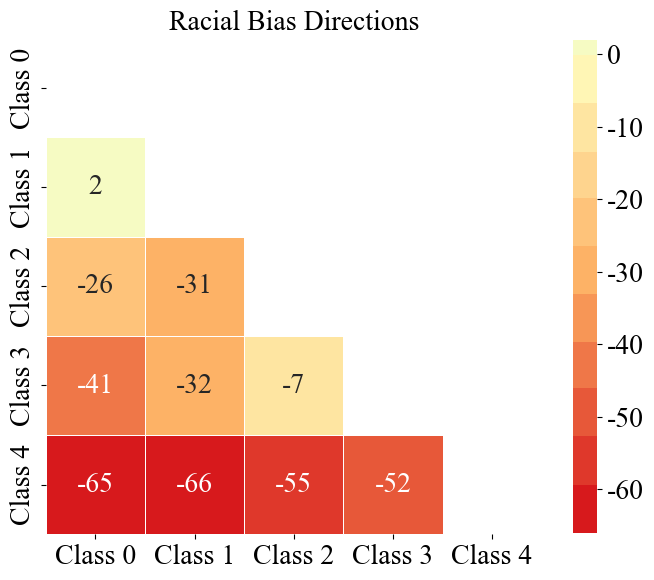

In [154]:
draw_sample_biases(racial_scores, 5, 'Racial Bias Directions')

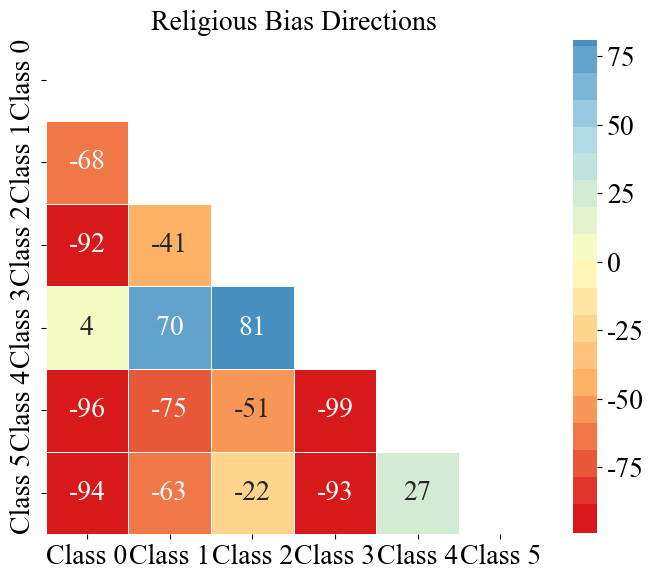

In [155]:
draw_sample_biases(religion_scores, 6, 'Religious Bias Directions')

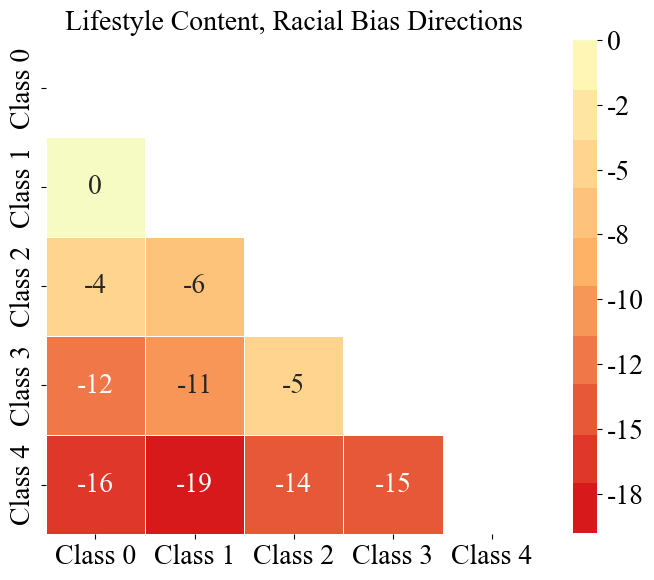

In [156]:
draw_sample_biases(ls_race_mw_scores, 5, 'Lifestyle Content, Racial Bias Directions')

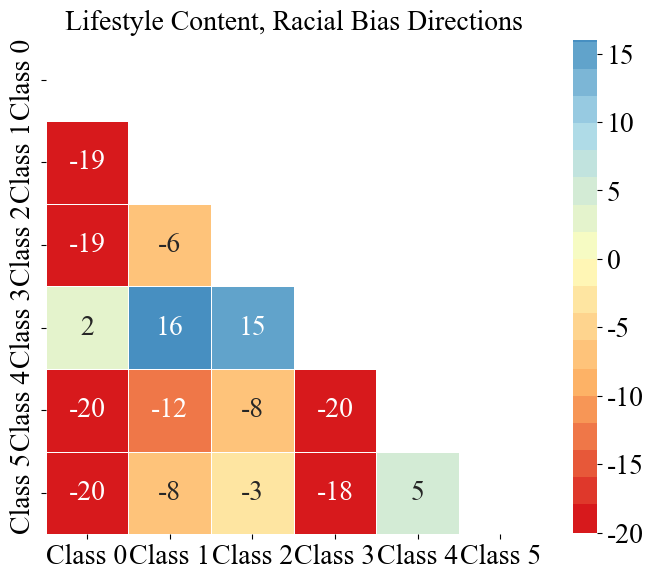

In [157]:
draw_sample_biases(ls_religion_mw_scores, 6, 'Lifestyle Content, Racial Bias Directions')

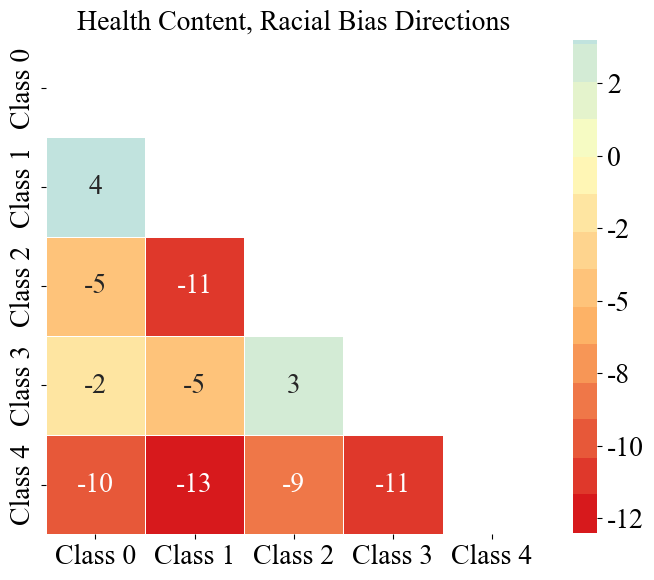

In [158]:

draw_sample_biases(health_race_mw_scores, 5, 'Health Content, Racial Bias Directions')

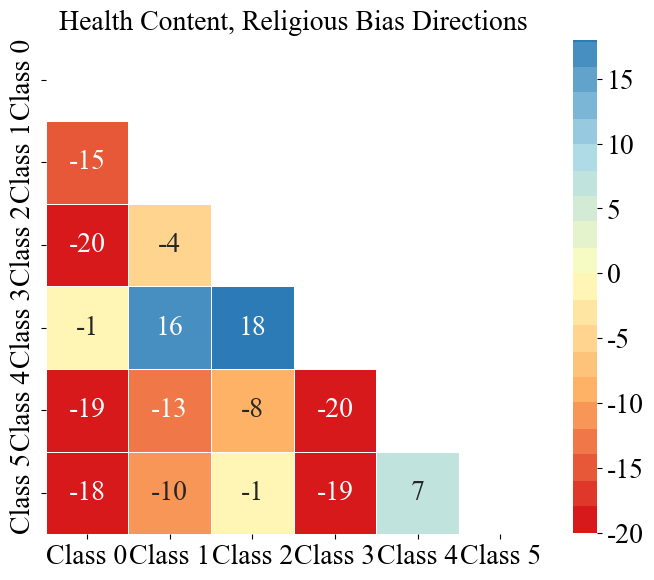

In [159]:
draw_sample_biases(health_religion_mw_scores, 6, 'Health Content, Religious Bias Directions')

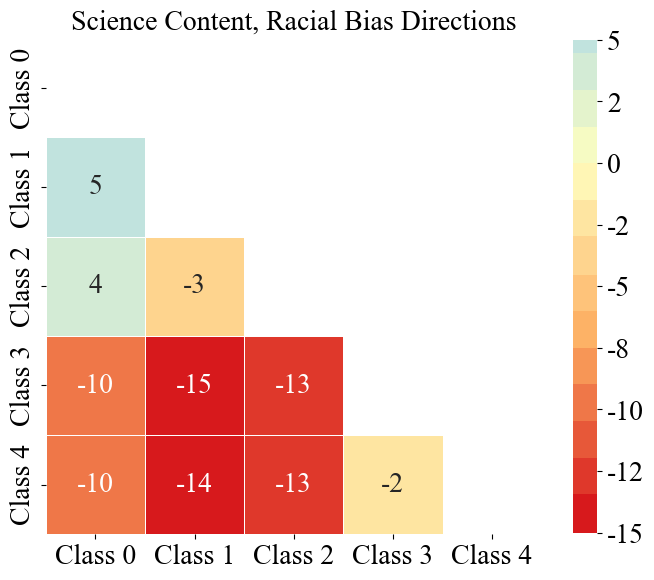

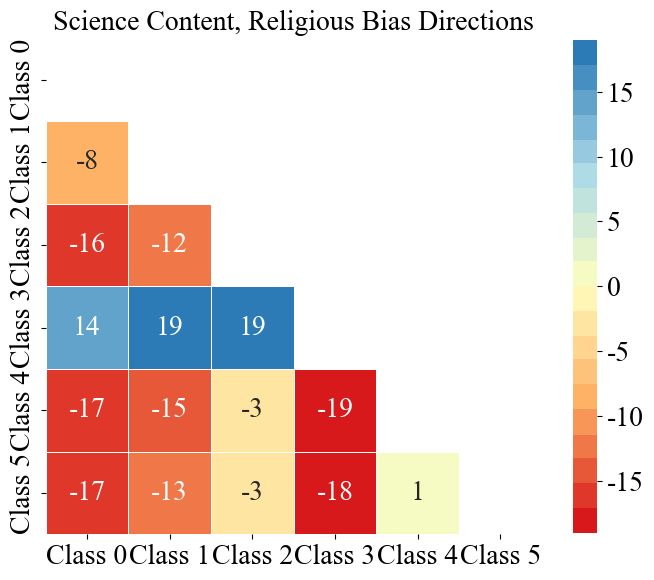

In [160]:
draw_sample_biases(science_race_mw_scores, 5, 'Science Content, Racial Bias Directions')
draw_sample_biases(science_religion_mw_scores, 6, 'Science Content, Religious Bias Directions')

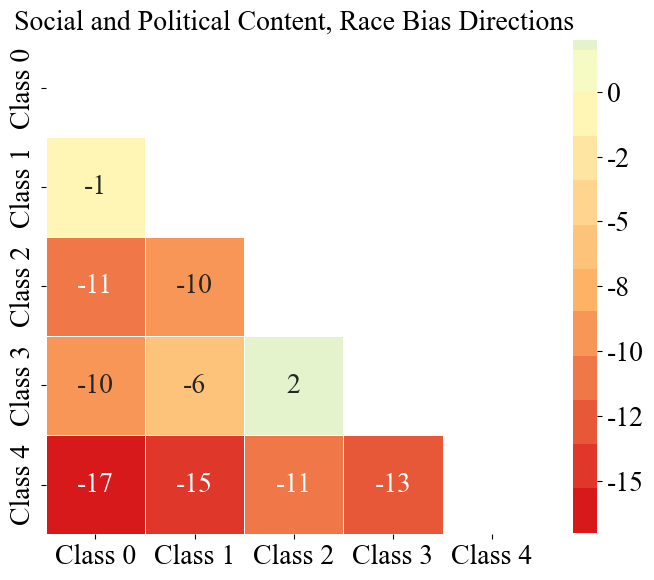

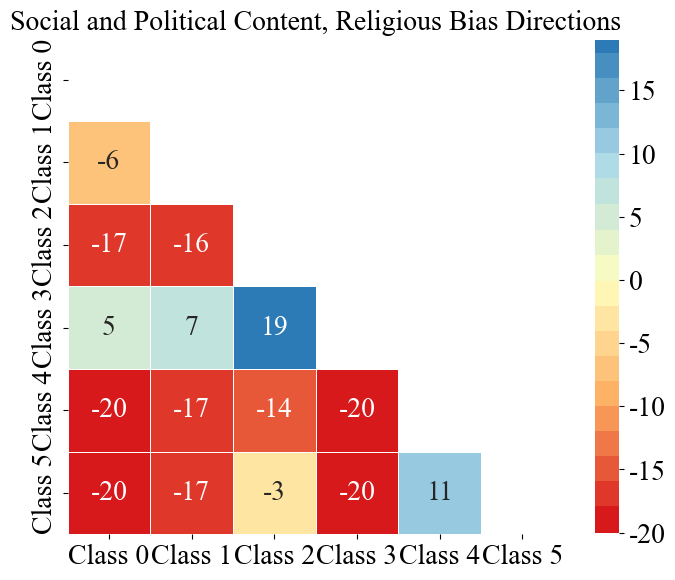

In [161]:
draw_sample_biases(social_race_mw_scores, 5, 'Social and Political Content, Race Bias Directions')
draw_sample_biases(social_religion_mw_scores, 6, 'Social and Political Content, Religious Bias Directions')

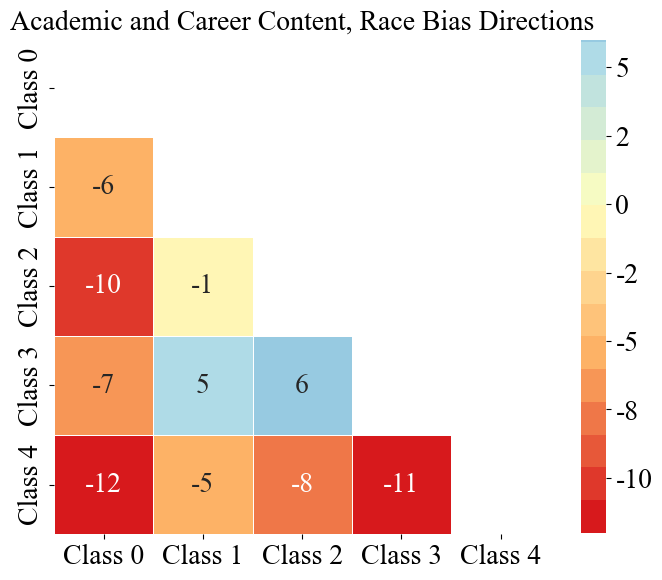

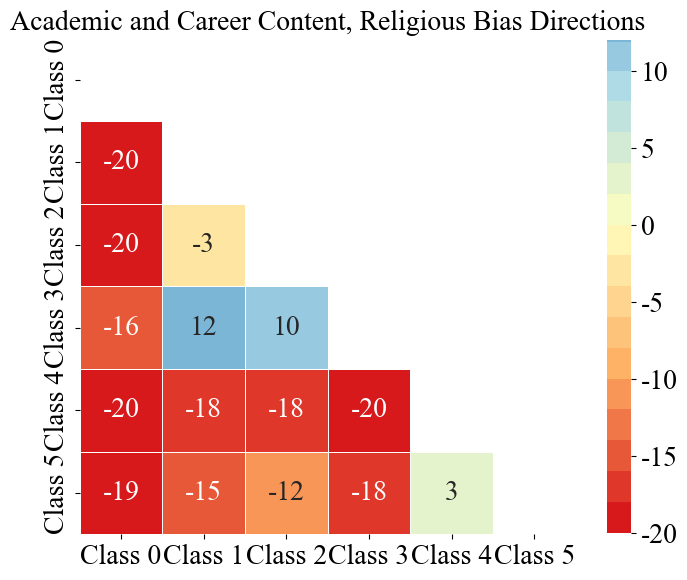

In [162]:
draw_sample_biases(academic_race_mw_scores, 5, 'Academic and Career Content, Race Bias Directions')
draw_sample_biases(academic_religion_mw_scores, 6, 'Academic and Career Content, Religious Bias Directions')